XS plotting
===========

This notebook uses the ``pyne.ace`` module to plot cross-sections.
ACE (A Compact ENDF) files are a point-wise representation of cross-section,
considered to be "continuous energy" (as in not discrete) for all practical
purposes.

ACE files originate from processing ENDFs (Evaluated Nuclear Data File) with
some cross section preparation code, such as NJOY.
ACE files already contain some form of approximation compared to ENDFs
(at least some form of doppler broadening, since ACE libraries are for a certain
temperature, and most likely assumptions regarding unresolved resonances and
how to represent them as points, but I would have to check more precisely to
make a strong statement), so in the future I would like to change this to using
ENDF for the plotting and making these assumptions explicit here.

In [1002]:
%matplotlib inline

latex = False

if latex:
    import matplotlib as mpl
    mpl.use("pgf")
    pgf_with_rc_fonts = {
        "font.family": "serif",
        "font.serif": [],                   # use latex default serif font
        "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
    }
    mpl.rcParams.update(pgf_with_rc_fonts)

import fnmatch
import os

import numpy as np
from scipy import interpolate as interp
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyne import ace
from pyne.data import atomic_mass

mpl.style.use('seaborn')

# n_mass = 1.00866491588
N_a = 6.02E23 # avogadro's stuff/mol
barn2cm = 1E-24

ene = 'Neutron energy (MeV)'

XS = '$ \Sigma $ (barn)'
XS_t = '$ \Sigma_{\mathrm{t}} (\mathrm{cm}^{-1}) $'
XS_e = '$ \Sigma_{\mathrm{e}} (\mathrm{cm}^{-1}) $'
XS_a = '$ \Sigma_{\mathrm{a}} (\mathrm{cm}^{-1}) $'
XS_f = '$ \Sigma_{\mathrm{f}} (\mathrm{cm}^{-1}) $'
XS_gamma = '$ \Sigma_{\gamma} (\mathrm{cm}^{-1}) $'
XS_alpha = '$ \Sigma_{\\alpha} (\mathrm{cm}^{-1}) $'

nut = '$ \\nu_{\mathrm{t}}$'
eta = '$ \eta $ '

ace_path = "/Users/rodrigo/opt/Serpent2/xsdata/jeff311/acedata/"


def save_plot(save):
    if save:
        plt.savefig(f'{save}.pdf', bbox_inches='tight')


def plot_loglog(energy, xs, xs_label, lw=0.5, title=None, save=None, ymin=None):
    fig, ax = plt.subplots()
    ax.loglog(energy, xs,linewidth=lw)
    ax.set(xlabel=ene,ylabel=xs_label,title=title)
    ax.set_ylim(ymin=ymin)
    save_plot(save)
    return fig, ax


def plot_semilogx(energy, semi, semi_label, lw=0.5, title=None, save=None, ylim=None):
    fig, ax = plt.subplots()
    ax.semilogx(energy, semi,linewidth=lw)
    ax.set(xlabel=ene,ylabel=semi_label,title=title)
    ax.set_ylim(ylim)
    save_plot(save)
    return fig, ax


def plot_ratio(energy, ratio, ratio_label, lw=0.5, title=None, save=None, ylim=(-0.05, 1.05)):
    fig, ax = plot_semilogx(energy, ratio, ratio_label, lw, title)
    ax.set_ylim(ylim)
    save_plot(save)
    return fig, ax


def plot_compare_mts(material, T, mts, mt_labels, lw=0.5, title=None, save=None, ylim=None):
    fig, ax = plt.subplots()
    for mt, mt_label in zip(mts, mt_labels):
        ax.loglog(material.energy(T), material.mt(mt, T),
                  label=mt_label,
                  linewidth=lw)
    ax.legend()
    ax.set_ylim(ylim)
    ax.set(xlabel=ene,ylabel=XS,title=title)
    save_plot(save)
    return fig, ax

Nuclide

It is interesting for us to encapsulate the concept of a nuclide, which has
mass, nuclear data, data for collisions such as logarithmic energy decrement,
etc. This class is a showcase example of Object Oriented Programming (OOP).
It is very easy to understand the idea behind putting all nuclide data together
so that it's organized and available at the right place.

In [1003]:
class Nuclide:
    def __init__(self,zzaaa, mass):
        self.zzaaa = zzaaa
        self.mass = mass  # g/mol or kg/kmol

        self.nuclear_data = self.load_ace(self.zzaaa)


    @staticmethod
    def load_ace(zzaaa):
        """
        The main class in ``pyne.ace`` is called ``Library``.
        It is instantiated using the name of an ACE file.
        Here we use the files distributed with Serpent.
        """
        for file in os.listdir(ace_path):
            if fnmatch.fnmatch(file, f'{zzaaa}*'):
                lib = ace.Library(ace_path + file)
        lib.read()
        return lib

    def at_T(self, T):
       return self.nuclear_data.tables[str(self.zzaaa) + f'.{(T//100):02}c']

    def energy(self, T):
        return self.at_T(T).energy

    def mt(self,mt, T):
        if mt == 1:
            return self.at_T(T).sigma_t
        else:
            return self.at_T(T).reactions[mt].sigma

    def nu_energy(self, T):
        return self.at_T(T).nu_t_energy

    def nu(self, T):
        return self.at_T(T).nu_t_value

    def co_alpha(self, n_mass=1.00866491588):
        return ((self.mass - n_mass)/(self.mass + n_mass))**2

    def min_collisions(self, initial_energy=2, final_energy=2.5E-8):
        alpha = self.co_alpha()
        return np.log(final_energy/initial_energy) / np.log(alpha)

    def ln_energy_decrement(self):
        alpha = self.co_alpha()
        return 1 + (alpha/(1 - alpha))*np.log(alpha)

    def ave_collisions(self, initial_energy=2, final_energy=2.5E-8):
        xi = self.ln_energy_decrement()
        return (1/xi) * np.log(initial_energy/final_energy)

    def moderating_power(self, table):
        xi = self.ln_energy_decrement()
        xse = self.nuclear_data.tables[table].reactions[2].sigma
        return xi * xse

    def moderating_ratio(self, table):
        mod_pow = self.moderating_power(table)
        xsa = self.nuclear_data.tables[table].reactions[102].sigma
        return mod_pow / xsa

"Light" Water: H$_2$O

In [1004]:
H1 = Nuclide(1001, atomic_mass('1H'))
O16 = Nuclide(8016, atomic_mass('16O'))

print(H1.co_alpha())
print(H1.ln_energy_decrement())
print(H1.ave_collisions())

1.7347868879654308e-07
0.9999972994201658
18.197586336672845


In [1005]:
water_den = 0.99656 # g / cm3
# water_den = 996.56 # kg / m3
water_T = 300

water_mm = 2*H1.mass + O16.mass

N_water = water_den / water_mm * N_a

N_H1 = N_water*2
N_O16 = N_water

print(N_H1)
print(N_O16)

H1_3 = H1.at_T(water_T)
O16_3 = O16.at_T(water_T)

# The "unionized" energy grid is a concept where all energy grids go through
# a union operation, and the resulting energy grid has all points from
# the individual grids. It costs more memory, but it's faster/easier to handle.
ueg = np.union1d(H1_3.energy, O16_3.energy)

keys = H1.nuclear_data.tables.keys()
for key in keys:
    print(np.array_equal(H1.at_T(water_T).energy,H1.nuclear_data.tables[key].energy))

6.661969022347847e+22
3.3309845111739236e+22
True
True
True
True
True
True


In [1006]:
ueg_H1_3_sigma_t = np.interp(ueg, H1_3.energy, H1_3.sigma_t)
ueg_O16_3_sigma_t = np.interp(ueg, O16_3.energy, O16_3.sigma_t)

Sigma_t_water = (N_H1*ueg_H1_3_sigma_t + N_O16*ueg_O16_3_sigma_t)*barn2cm

ueg_H1_3_sigma_e = np.interp(ueg, H1_3.energy, H1_3.reactions[2].sigma)
ueg_O16_3_sigma_e = np.interp(ueg, O16_3.energy, O16_3.reactions[2].sigma)

Sigma_e_H1 = N_H1*ueg_H1_3_sigma_e*barn2cm
Sigma_e_O16 = N_O16*ueg_O16_3_sigma_e*barn2cm
Sigma_e_water = Sigma_e_H1 + Sigma_e_O16
sigma_e_water = Sigma_e_water/N_water/barn2cm

ueg_H1_3_sigma_gamma = np.interp(ueg, H1_3.energy, H1_3.reactions[102].sigma)
ueg_O16_3_sigma_gamma = np.interp(ueg, O16_3.energy, O16_3.reactions[102].sigma)

Sigma_gamma_water = (N_H1*ueg_H1_3_sigma_gamma + N_O16*ueg_O16_3_sigma_gamma)*barn2cm
sigma_gamma_water = Sigma_gamma_water/N_water/barn2cm

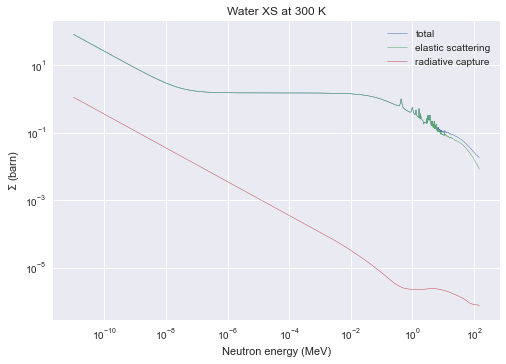

In [1007]:
fig, ax = plt.subplots()
ax.loglog(ueg, Sigma_t_water, label='total', linewidth=0.5)
ax.loglog(ueg, Sigma_e_water, label='elastic scattering', linewidth=0.5)
ax.loglog(ueg, Sigma_gamma_water, label='radiative capture', linewidth=0.5)
ax.set(xlabel=ene,ylabel=XS,
       title=f'Water XS at {water_T} K')
ax.legend()
plt.savefig(f'Water_XS_{water_T}.pdf')

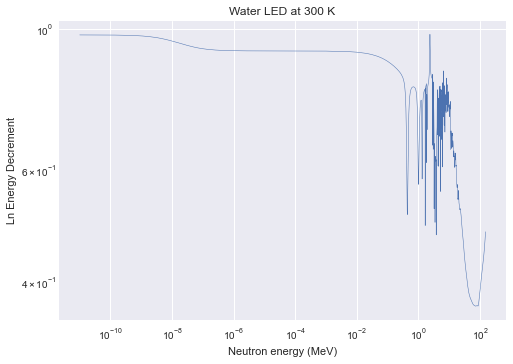

In [1008]:
ln_energy_decrement_water = (Sigma_e_H1*H1.ln_energy_decrement() \
                            +Sigma_e_O16*O16.ln_energy_decrement()) \
                            /Sigma_e_water

fig, ax = plt.subplots()
ax.loglog(ueg, ln_energy_decrement_water, label=f'{water_T} K', linewidth=0.5)
ax.set(xlabel=ene,ylabel='Ln Energy Decrement',
       title=f'Water LED at {water_T} K')
plt.savefig(f'Water_LED_{water_T}.pdf')

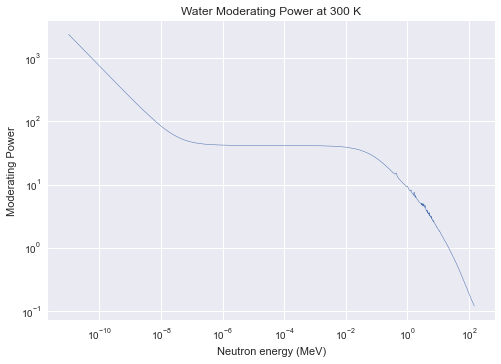

In [1009]:
mp = ln_energy_decrement_water*sigma_e_water

fig, ax = plt.subplots()
ax.loglog(ueg, mp, label=f'{water_T} K', linewidth=0.5)
ax.set(xlabel=ene,ylabel='Moderating Power',
       title=f'Water Moderating Power at {water_T} K')
plt.savefig(f'Water_MP_{water_T}.pdf')

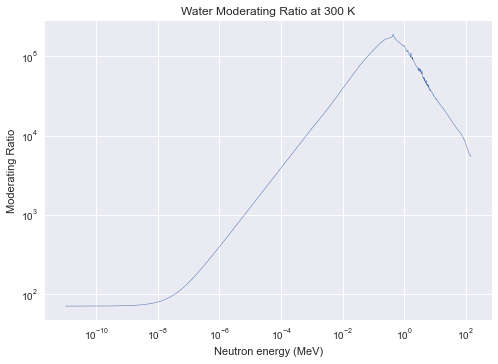

In [1010]:
mr = mp/sigma_gamma_water

fig, ax = plt.subplots()
ax.loglog(ueg, mr, label=f'{water_T} K', linewidth=0.5)
ax.set(xlabel=ene,ylabel='Moderating Ratio',
       title=f'Water Moderating Ratio at {water_T} K')
plt.savefig(f'Water_MR_{water_T}.pdf')

In [1011]:
E = 6.5E-8

print(f'Water data at {water_T} with neutron energy {E}')
led_E = interp.interp1d(ueg, ln_energy_decrement_water)
print('Ln Energy Decrement', led_E(E))

xs_e_E = interp.interp1d(ueg, sigma_e_water)
print('Microscopic Elastic XS', xs_e_E(E))
mp_E = interp.interp1d(ueg, mp)
print('Moderating Power', mp_E(E))

xs_gamma_E = interp.interp1d(ueg, sigma_gamma_water)
print('Microscopic Capture XS', xs_gamma_E(E))
mr_E = interp.interp1d(ueg, mr)
print('Moderating Ratio', mr_E(E))

Water data at 300 with neutron energy 6.5e-08
Ln Energy Decrement 0.9352466502348822
Microscopic Elastic XS 52.9752496
Moderating Power 49.54507757734164
Microscopic Capture XS 0.41495418112000004
Moderating Ratio 119.4431714194299


Material

We say with water that a mix of nuclides makes up for a messy thing, so again
we use a class to encapsulate a material, which is a mix of nuclides.

In [1012]:
class Material:
    def __init__(self, nuclides, atom_densities):
        self.nuclides = nuclides
        self.atom_densities = atom_densities

    @classmethod
    def from_density(cls, nuclides, fractions, material_density):
        material_mm = 0
        for nuclide, fraction in zip(nuclides, fractions):
            material_mm += fraction*nuclide.mass

        N_material = material_density / material_mm * N_a

        atom_densities = []
        for fraction in fractions:
            atom_densities.append(N_material*fraction)

        return cls(nuclides, atom_densities)

    def energy(self, T):
        unionized_energy_grid = self.nuclides[0].at_T(T).energy
        if len(self.nuclides) > 1:
            for nuclide in self.nuclides[1:]:
                unionized_energy_grid = np.union1d(unionized_energy_grid,
                                                   nuclide.at_T(T).energy)

        return unionized_energy_grid

    def mt(self,mt, T):
        ueg = self.energy(T)
        Macro = np.zeros_like(ueg)
        for nuclide, atom_density in zip(self.nuclides, self.atom_densities):
            nuclide_T = nuclide.at_T(T)
            if mt == 1:
                micro = np.interp(ueg,
                                  nuclide_T.energy, nuclide_T.sigma_t)
            else:
                micro = np.interp(ueg,
                                  nuclide_T.energy, nuclide_T.reactions[mt].sigma)
            Macro += micro*atom_density

        return Macro*barn2cm

    def Sigma_t(self, T):
        return self.mt(1, T)

    def Sigma_e(self, T):
        return self.mt(2, T)

    def Sigma_gamma(self, T):
        return self.mt(102, T)

    def Sigma_f(self, T):
        return self.mt(18, T)

    def Sigma_a(self, T):
        return self.Sigma_gamma(T) + self.Sigma_f(T)

    # def nu_energy(self, T):
    #     unionized_energy_grid = self.nuclides[0].nu_energy(T)
    #     if len(self.nuclides) > 1:
    #         for nuclide in self.nuclides[1:]:
    #             unionized_energy_grid = np.union1d(unionized_energy_grid,
    #                                                nuclide.nu_energy(T))
    #
    #     return unionized_energy_grid
    #
    # def nu(self, T):
    #     ueg = self.nu_energy(T)
    #     mat_nu = np.zeros_like(ueg)
    #     for nuclide, atom_density in zip(self.nuclides, self.atom_densities):
    #         nuclide_T = nuclide.at_T(T)
    #         nuc_nu = np.interp(ueg,
    #                            nuclide_T.nu_t_energy, nuclide_T.nu_t_value)
    #         mat_nu += nuc_nu*atom_density
    #
    #     return mat_nu

    def eta(self, T):
        ueg = self.energy(T)
        mat_eta = np.zeros_like(ueg)
        for nuclide, atom_density in zip(self.nuclides, self.atom_densities):
            nuclide_T = nuclide.at_T(T)

            sigma_f = np.interp(ueg, nuclide_T.energy, nuclide_T.reactions[18].sigma)
            nu = np.interp(ueg, nuclide_T.nu_t_energy, nuclide_T.nu_t_value)

            mat_eta += nu*sigma_f*atom_density

        return mat_eta*barn2cm/self.Sigma_a(T)

    def ln_energy_decrement(self, T):
        ueg = self.energy(T)
        led = np.zeros_like(ueg)
        for nuclide, atom_density in zip(self.nuclides, self.atom_densities):
            sigma_e_nuclide = np.interp(ueg, nuclide.at_T(T).energy, nuclide.mt(2, T))
            led += sigma_e_nuclide*atom_density*barn2cm*nuclide.ln_energy_decrement()
        led /= self.Sigma_e(T)

        return led

    def moderating_power(self, T):
        N = np.min(self.atom_densities)
        sigma_e = self.Sigma_e(T)/N/barn2cm
        return self.ln_energy_decrement(T)*sigma_e

    def moderating_ratio(self, T):
        N = np.min(self.atom_densities)
        sigma_gamma = self.Sigma_gamma(T)/N/barn2cm
        return self.moderating_power(T)/sigma_gamma

Heavy Water: D$_2$O

In [1013]:
H2 = Nuclide(1002, atomic_mass('2H'))

print(H2.ln_energy_decrement())
print(H2.ave_collisions())

hw_den = 1.1056 # g / cm3
hw_T = 300

hw = Material.from_density((H2, O16), (2, 1), hw_den)

ueg = hw.energy(hw_T)

0.7261327281054011
25.06089656655265


(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'Heavy Water XS at 300 K'}, xlabel='Neutron energy (MeV)', ylabel='$ \\Sigma $ (barn)'>)

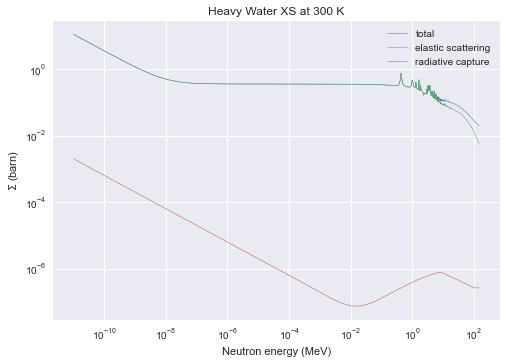

In [1014]:
plot_compare_mts(hw, hw_T,
                 (1, 2, 102), ('total', 'elastic scattering', 'radiative capture'),
                 title=f'Heavy Water XS at {hw_T} K',
                 save=f'Heavy_Water_XS_{hw_T}')

(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'Heavy Water Moderating Ratio at 300 K'}, xlabel='Neutron energy (MeV)', ylabel='Moderating Ratio'>)

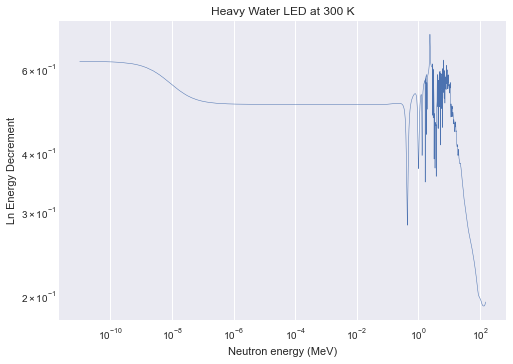

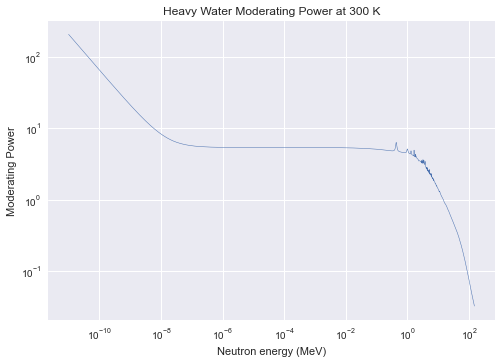

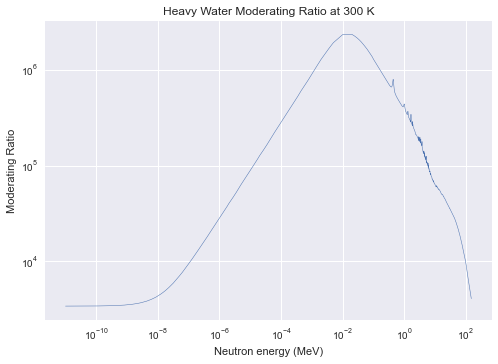

In [1015]:
led = hw.ln_energy_decrement(hw_T)

plot_loglog(ueg, led, xs_label='Ln Energy Decrement',
            title=f'Heavy Water LED at {hw_T} K',
            save=f'Heavy_Water_LED_{hw_T}')

mp = hw.moderating_power(hw_T)

plot_loglog(ueg, mp, xs_label='Moderating Power',
            title=f'Heavy Water Moderating Power at {hw_T} K',
            save=f'Heavy_Water_MP_{hw_T}')

mr = hw.moderating_ratio(hw_T)

plot_loglog(ueg, mr, xs_label='Moderating Ratio',
            title=f'Heavy Water Moderating Ratio at {hw_T} K',
            save=f'Heavy_Water_MR_{hw_T}')

In [1016]:
E = 6.5E-8

print(f'Heavy water data at {hw_T} with neutron energy {E}')
led_E = interp.interp1d(ueg, led)
print('Ln Energy Decrement', led_E(E))
mp_E = interp.interp1d(ueg, mp)
print('Moderating Power', mp_E(E))
mr_E = interp.interp1d(ueg, mr)
print('Moderating Ratio', mr_E(E))

Heavy water data at 300 with neutron energy 6.5e-08
Ln Energy Decrement 0.5184773572060137
Moderating Power 5.896052862930301
Moderating Ratio 7840.207812241822


Uranium

In [1017]:
U235 = Nuclide(92235, atomic_mass('235U'))
U238 = Nuclide(92238, atomic_mass('238U'))

# densities
uranium_den = 19.1
uranium_dio = 10.97

uranium_T = 1200

Natural Uranium

In [1018]:
U235_f = 0.0072
U238_f = 1 - U235_f

uranium = Material.from_density((U235, U238), (U235_f, U238_f), uranium_den)

ueg = uranium.energy(uranium_T)

(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'Uranium $\\eta$ at 1200 K with 0.0072 U235'}, xlabel='Neutron energy (MeV)', ylabel='$ \\eta $ '>)

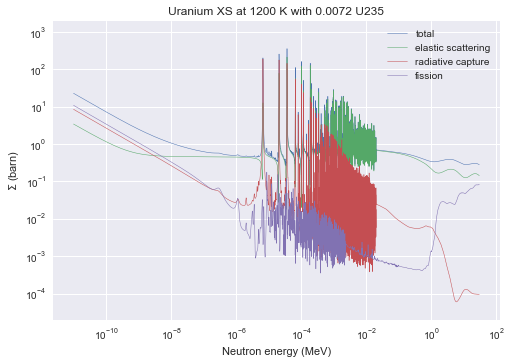

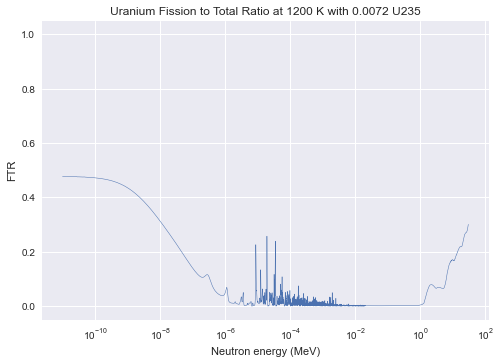

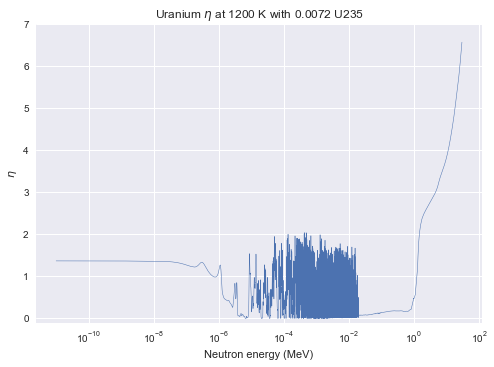

In [1019]:
plot_compare_mts(uranium, uranium_T,
                 (1, 2, 102, 18), ('total', 'elastic scattering', 'radiative capture', 'fission'),
                 title=f'Uranium XS at {uranium_T} K with {U235_f} U235',
                 save=f'Uranium_XS_{uranium_T}_{U235_f}',
                 ylim=(2E-5, 2E3))

uranium_FTR = uranium.Sigma_f(uranium_T)/uranium.Sigma_t(uranium_T)

plot_ratio(ueg, uranium_FTR, 'FTR',
           title=f'Uranium Fission to Total Ratio at 1200 K with {U235_f} U235',
           save=f'Uranium_FTR_{uranium_T}_{U235_f}')

plot_semilogx(uranium.energy(uranium_T), uranium.eta(uranium_T), semi_label=eta,
              title=f'Uranium $\eta$ at {uranium_T} K with {U235_f} U235',
              save=f'Uranium_eta_{uranium_T}_{U235_f}',
              ylim=(-0.1, 7))

Enriched Uranium

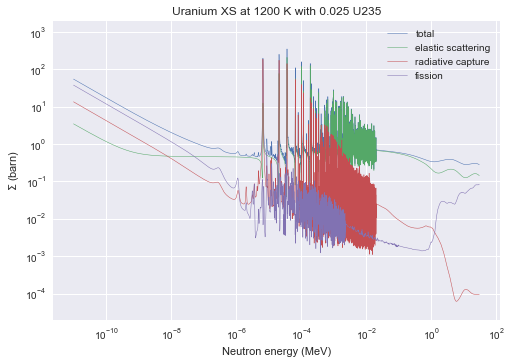

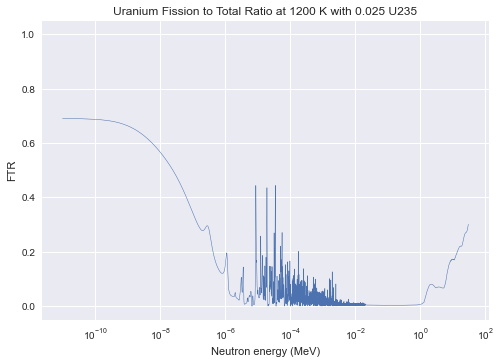

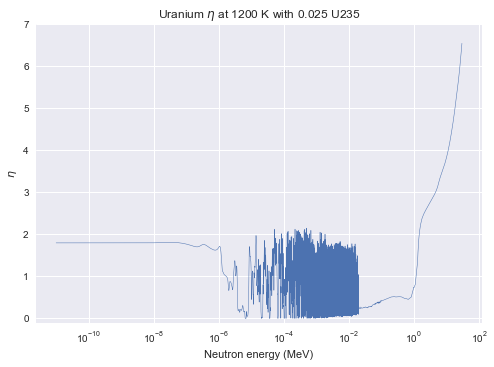

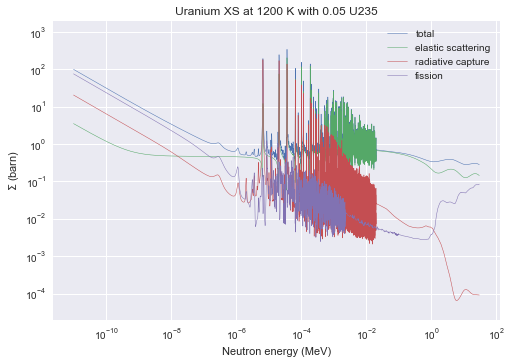

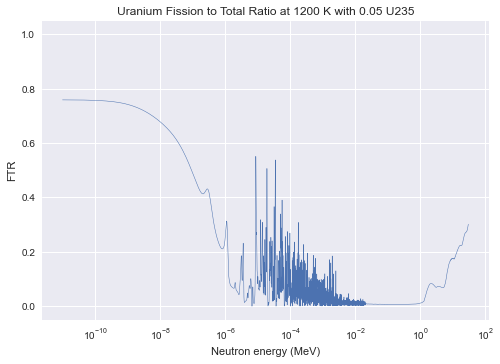

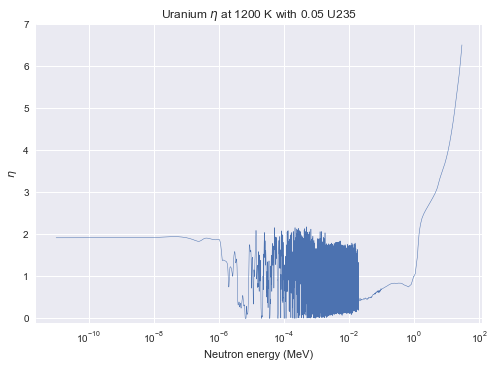

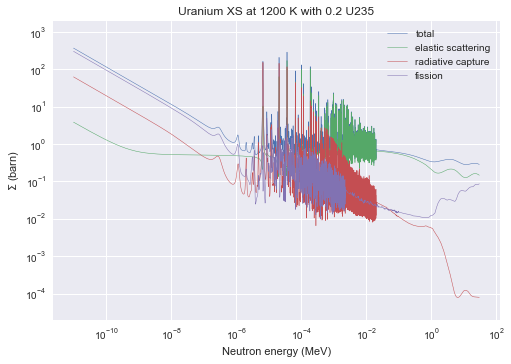

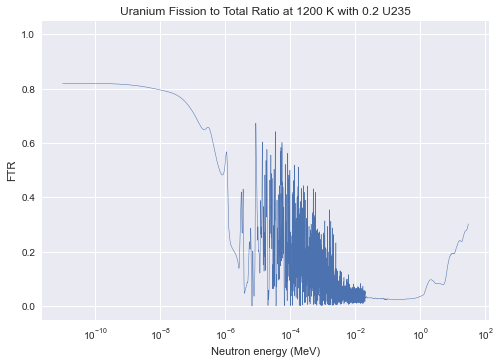

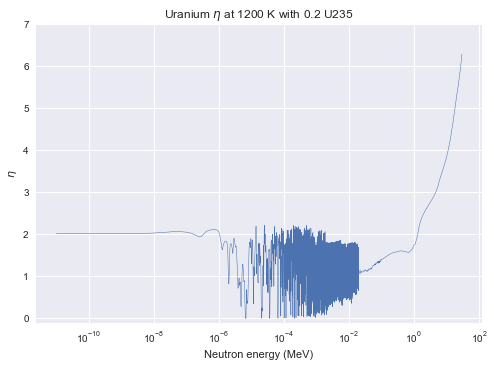

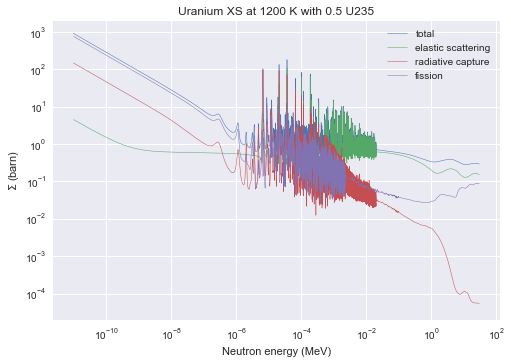

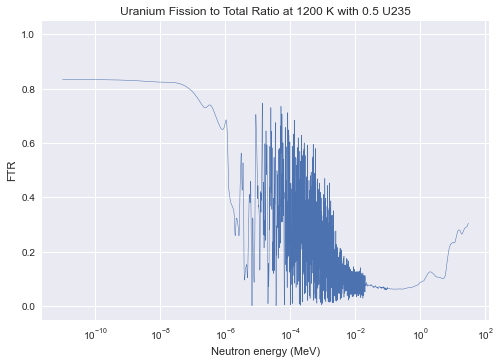

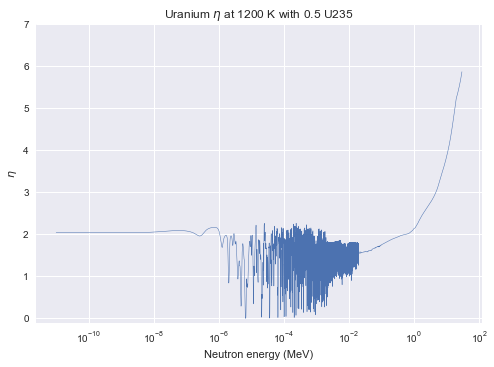

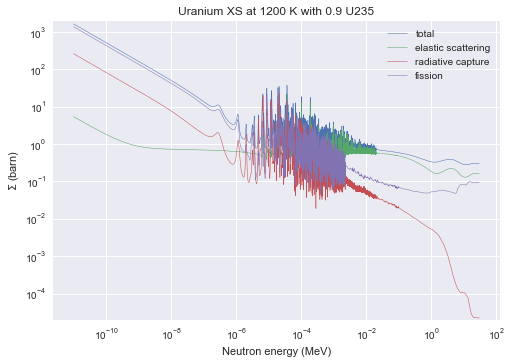

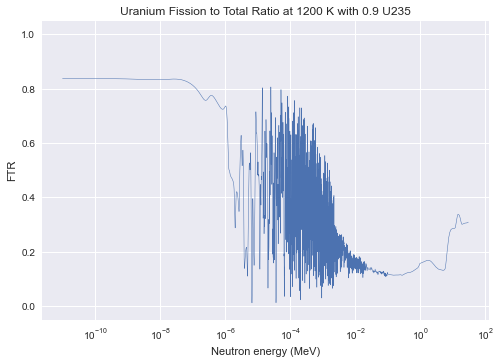

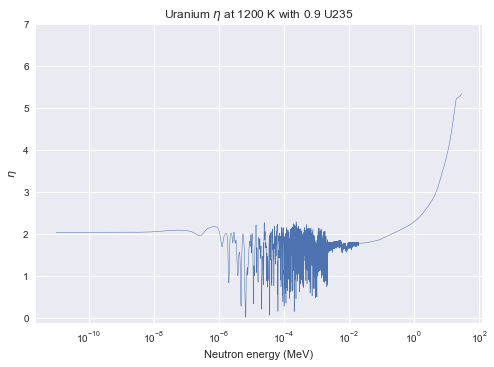

In [1020]:
U235_fs = [0.025, 0.05, 0.20, 0.50, 0.90]

for U235_f in U235_fs:
    U238_f = 1 - U235_f

    uranium = Material.from_density((U235, U238), (U235_f, U238_f), uranium_den)

    ueg = uranium.energy(uranium_T)

    plot_compare_mts(uranium, uranium_T,
                     (1, 2, 102, 18), ('total', 'elastic scattering', 'radiative capture', 'fission'),
                     title=f'Uranium XS at {uranium_T} K with {U235_f} U235',
                     save=f'Uranium_XS_{uranium_T}_{U235_f}',
                     ylim=(2E-5, 2E3))

    uranium_FTR = uranium.Sigma_f(uranium_T)/uranium.Sigma_t(uranium_T)

    plot_ratio(ueg, uranium_FTR, 'FTR',
               title=f'Uranium Fission to Total Ratio at 1200 K with {U235_f} U235',
               save=f'Uranium_FTR_{uranium_T}_{U235_f}')

    plot_semilogx(uranium.energy(uranium_T), uranium.eta(uranium_T), semi_label=eta,
                  title=f'Uranium $\eta$ at {uranium_T} K with {U235_f} U235',
                  save=f'Uranium_eta_{uranium_T}_{U235_f}',
                  ylim=(-0.1, 7))